# Lesson 13, Workalong 02: Plotting geospatial data

This workalong shows how to use `rioxarray` to read a raster file (a GeoTIFF in this case) to add topography to our plot.  It also shows some tricks for getting good-looking topo plots.

In [2]:
""" Import libraries """
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl
import rioxarray
import cartopy
import numpy as np
import cmocean

mpl.style.use('seaborn-v0_8-poster')

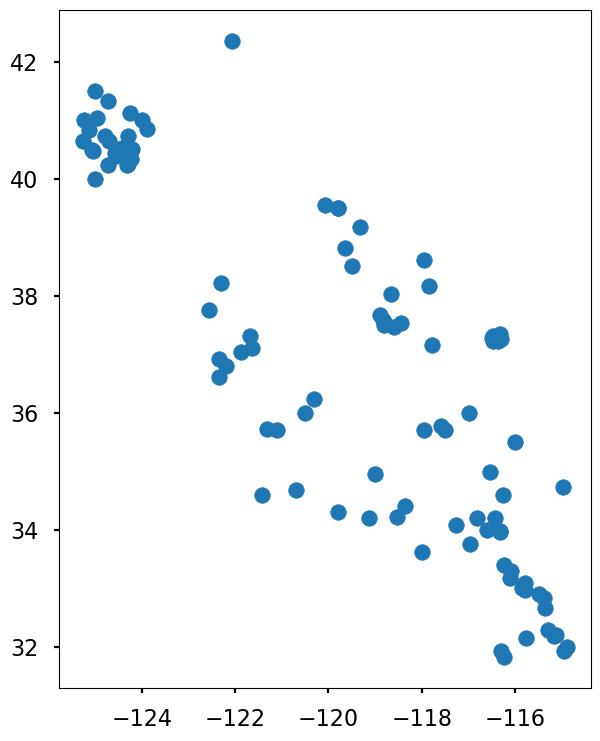

In [3]:
""" Load the earthquake data from the earlier exercise. """
data_file = "ca_earthquakes.shp.zip"

# Load the data into a GeoDataFrame
ca_earthquakes_gdf = gpd.read_file(data_file)
ca_earthquakes_gdf.plot();

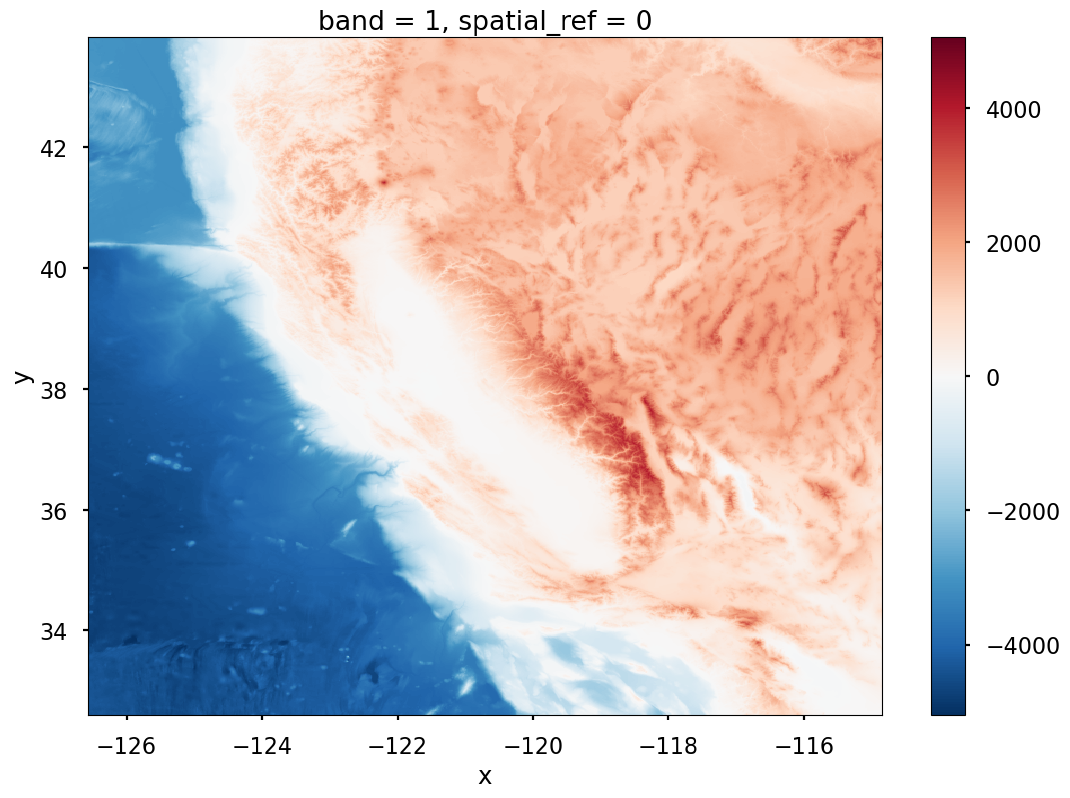

In [4]:
""" Load the topo / bathymetry data. """

# file from https://www.ncei.noaa.gov/maps/grid-extract/. useful for raster
# set the filepath
topo_bathy_path = "https://github.com/taobrienlbl/advanced_earth_science_data_analysis/raw/09188e9e6a0cf230f8473c0ae95d2e1b9079df3a/lessons/13_geospatial_intro/data/western_us_topo_bathy_subset.tiff"


# Load the data with rasterio
topo_bathy = rioxarray.open_rasterio(topo_bathy_path)
topo_bathy.plot()

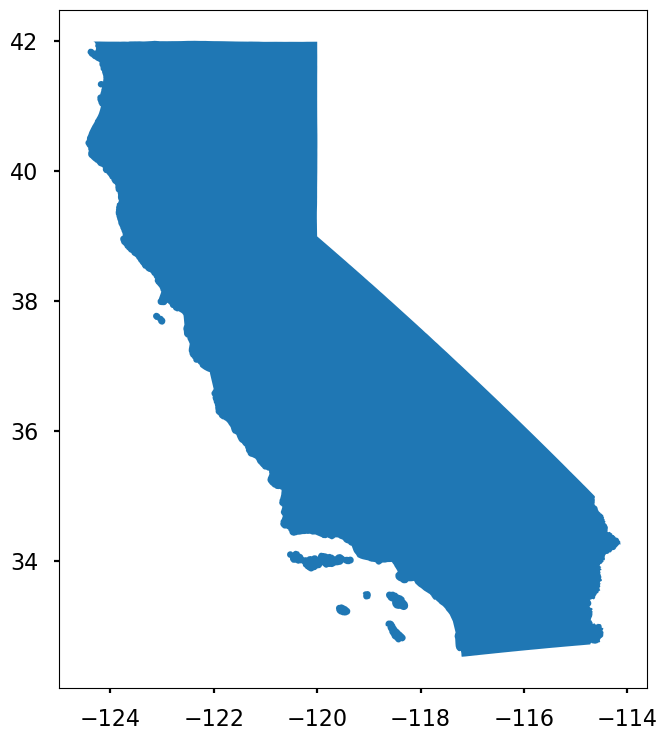

In [14]:
""" Load the state boundary data. """
data_file2 = "ca_boundary.shp.zip"

# Load the data into a GeoDataFrame
ca_boundary = gpd.read_file(data_file2)
ca_boundary.plot();

ca_boundary_proj = ca_boundary.to_crs(cartopy.crs.PlateCarree())

In [ ]:
#look at spacing of x values in... array
topo_bathy.x

<xarray.DataArray 'x' (x: 703)>
array([-126.558337, -126.54167 , -126.525003, ..., -114.891667, -114.875   ,
       -114.858333])
Coordinates:
  * x            (x) float64 -126.6 -126.5 -126.5 ... -114.9 -114.9 -114.9
    spatial_ref  int32 0

In [ ]:

# can get spacing 
topo_bathy.x.diff('x').values[0] 
#we only need the difference between two of the values because it is constant

0.016666671619617546

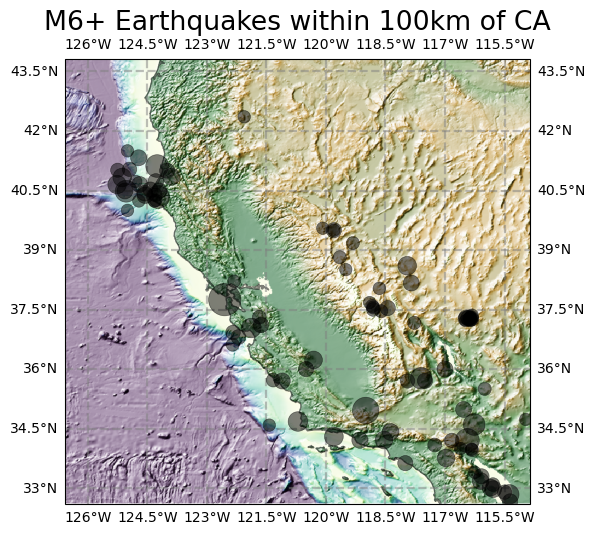

In [15]:
""" Generate a plot of earthquake locations on top of the topography / bathymetry data. """

#set projection
projection = cartopy.crs.PlateCarree(central_longitude=-120)

#create fig and axis
fig, ax = plt.subplots(figsize = (6,6), subplot_kw={"projection": projection})

# get projection as PROJ4 string
#proj4 = projection.PROJ4__init

# ******************************
# create hillshade of topo data
# ******************************
# create a light source for hillshade
ls = mpl.colors.LightSource(azdeg=315, altdeg=45) #altitude and azimuth of sun

# re project topo data just in case
ax_proj = ax.projection.proj4_init
topo_bathy_rxr_proj = topo_bathy #.rio.reproject(ax_proj)

# x and y grid spacing
dx = abs(topo_bathy.x.diff('x').values[0])
dy = abs(topo_bathy.x.diff('x').values[0]) #have to do abs bc y dif is negative

#   in degrees. convert to meters
rearth = 6371000  # radius? in meters
dx_meters = float(np.deg2rad(dx) * rearth * np.cos(np.deg2rad(topo_bathy.y[0])))
        # spacing between lon lines is variable; gets shorter going north
dy_meters = float(np.deg2rad(dy) * rearth)

# generate a blended hillshade
blend = ls.shade(
    topo_bathy_rxr_proj.values.squeeze(),
    cmap=cmocean.cm.topo,
    vmin = -3000, vmax = 3000,
    blend_mode="hsv", # look up matplotlib topographic hillshade for more
    dx=dx_meters, dy=dy_meters,
    vert_exag=10,
    )

# plot the hillshade
left, bottom, right, top = topo_bathy_rxr_proj.rio.bounds()
extent = [left, right, bottom, top]

ax.set_extent(extent, crs=cartopy.crs.PlateCarree())

ax.imshow(blend, extent=extent, transform=cartopy.crs.PlateCarree(), zorder=0)


# ************
# plot eq data
# ************
# convert the earthquake data to this projection
ca_earthquakes_gdf_proj = ca_earthquakes_gdf.to_crs(ax_proj)
# plot the earthquake locations with magnitude proportional to size
ca_earthquakes_gdf_proj.plot(
    ax = ax,
    color = "black",
    markersize = np.exp(ca_earthquakes_gdf_proj.mag)/5,
    zorder = 10, #what is this? order of which things plot. higher z order = more likely to plot on top
    alpha = 0.5,
    )

#add geographic features, gridlines
gl = ax.gridlines(draw_labels=True, color="gray", alpha=0.5, linestyle="--")
ax.coastlines(resolution="10m", color="black", linewidth=1, alpha = 0.5)


#convert state boundary to this projection 
#ax_proj = ax.projection.proj4_init
#ca_boundary_proj = ca_boundary #.rio.reproject(ax_proj)
# add state
ca_boundary_proj.plot(ax=ax, facecolor="none", edgecolor="black", linewidth = 1, transform = projection, zorder = 15)
#ax.add_geometries(ca_boundary, crs=cartopy.crs.PlateCarree())
# forget it

ax.set_title("M6+ Earthquakes within 100km of CA")

# set the extent
plt.show();
